# Machine Learning models on Mismatch Response data

In this notebook: 
- Necessary imports
- SVM model 
- Logistic Regression model
- Decision Tree model

## Imports

In [1]:
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
import seaborn as sn
import matplotlib.pyplot as plt
import ipywidgets as widgets

import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
import helper_functions as hf # library useful for eeg and erp data cleaning
import epod_helper

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,\
GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow import keras
from tensorflow.keras import layers

2022-10-19 09:22:11.981652: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 09:22:12.092812: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-19 09:22:12.121385: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-19 09:22:12.649568: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
csv = widgets.RadioButtons(
    options=['df_mmr_ch_complete.csv', 'df_mmr_ch_literature.csv', 'df_mmr_ch_ttest.csv', 'df_mmr_ch_connectivity.csv'],
#    value='pineapple', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='Pick sensors',
    disabled=False
)
display(csv)

RadioButtons(description='Pick sensors', options=('df_mmr_ch_complete.csv', 'df_mmr_ch_literature.csv', 'df_mm…

In [3]:
csv = str(csv.value)

In [4]:
df = pd.read_csv(csv, sep = ',')
df.head()

,Group_AccToParents,std_AF3,std_AF4,std_C3,std_C4,std_CP1,std_CP2,std_CP5,std_CP6,std_Cz,...,max_P7,max_P8,max_PO3,max_PO4,max_Pz,max_T7,max_T8,ParticipantID,test,sex
0,1,0.000001,0.000001,4.808342e-07,1.594913e-06,5.019738e-07,0.000001,7.492325e-07,0.000002,4.108746e-07,...,0.000003,0.000001,0.000002,0.000001,9.479040e-07,0.000001,0.000001,101,a,1
1,1,0.000002,0.000002,1.655713e-06,2.481066e-06,1.759369e-06,0.000003,1.640413e-06,0.000004,1.503068e-06,...,0.000015,0.000014,0.000007,0.000010,9.259968e-06,0.000003,0.000008,103,a,0
2,1,0.000001,0.000001,5.153498e-07,9.155640e-07,6.266883e-07,0.000001,8.980694e-07,0.000002,4.378937e-07,...,0.000004,0.000005,0.000004,0.000004,2.285211e-06,0.000003,0.000008,104,a,1
3,1,0.000002,0.000004,7.195861e-07,1.174368e-06,8.272699e-07,0.000001,1.437435e-06,0.000001,8.230323e-07,...,0.000006,0.000007,0.000002,0.000002,2.689267e-06,0.000012,0.000010,105,a,0
4,0,0.000002,0.000002,6.335705e-07,2.356464e-06,7.885711e-07,0.000002,2.304256e-06,0.000002,7.034887e-07,...,0.000009,0.000007,0.000004,0.000007,4.757814e-06,0.000004,0.000004,106,a,1


In [3]:
dfcor = df.corr()

In [4]:
dfcor

,Group_AccToParents,std_AF4,std_FC5,std_O1,std_PO4,std_Pz,sur_AF4,sur_FC5,sur_O1,sur_PO4,...,min_PO4,min_Pz,max_AF4,max_FC5,max_O1,max_PO4,max_Pz,ParticipantID,sex,age_months
Group_AccToParents,1.000000,0.113331,-0.194020,0.167952,0.202560,0.175488,0.222574,0.211188,0.119911,0.134901,...,-0.032421,0.024676,0.264299,0.037364,0.186655,0.205919,0.104989,-0.179183,-0.125751,0.056963
std_AF4,0.113331,1.000000,0.569919,0.249322,0.456250,0.255249,-0.026736,-0.063640,0.045203,-0.150305,...,-0.330596,-0.119295,0.586651,0.384446,0.243992,0.156942,0.166506,-0.022457,-0.173474,-0.018364
std_FC5,-0.194020,0.569919,1.000000,0.125497,0.211688,0.350651,-0.216218,-0.418392,0.178924,0.004421,...,-0.090146,-0.233700,0.186683,0.337689,0.196349,0.144628,0.240425,-0.070729,-0.143108,0.162388
std_O1,0.167952,0.249322,0.125497,1.000000,0.542458,0.280370,0.120088,-0.044708,0.173378,0.081115,...,-0.220800,0.044582,0.280854,-0.000968,0.891982,0.504172,0.280900,-0.147784,-0.154512,-0.053243
std_PO4,0.202560,0.456250,0.211688,0.542458,1.000000,0.429463,-0.043960,-0.146625,0.065738,-0.062502,...,-0.616463,-0.204591,0.271705,-0.029627,0.482848,0.523471,0.229165,0.123857,-0.186028,0.069905
std_Pz,0.175488,0.255249,0.350651,0.280370,0.429463,1.000000,-0.023730,-0.143024,0.431837,0.180936,...,-0.020470,-0.266277,0.146527,0.075262,0.413195,0.351825,0.692582,0.061860,-0.105194,0.178925
sur_AF4,0.222574,-0.026736,-0.216218,0.120088,-0.043960,-0.023730,1.000000,0.661329,0.226433,0.289806,...,0.204939,0.385086,0.720715,0.418673,0.212129,0.167775,0.257150,0.062838,0.066664,-0.075940
sur_FC5,0.211188,-0.063640,-0.418392,-0.044708,-0.146625,-0.143024,0.661329,1.000000,0.241644,0.295152,...,0.249573,0.296361,0.420922,0.576363,0.084394,0.082045,0.052622,0.112534,-0.010386,-0.182158
sur_O1,0.119911,0.045203,0.178924,0.173378,0.065738,0.431837,0.226433,0.241644,1.000000,0.573647,...,0.418362,0.157309,0.144534,0.257125,0.576176,0.362917,0.496318,-0.109024,-0.013550,0.169952
sur_PO4,0.134901,-0.150305,0.004421,0.081115,-0.062502,0.180936,0.289806,0.295152,0.573647,1.000000,...,0.625260,0.380053,0.092975,0.196023,0.330429,0.718172,0.505172,-0.118851,0.051309,0.073801


In [5]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(dfcor, 50))

Top Absolute Correlations
std_O1   max_O1        0.943107
sur_FC5  min_FC5       0.933901
std_FC5  min_FC5       0.913600
min_AF4  min_FC5       0.910997
std_O1   min_O1        0.887300
sur_AF4  min_AF4       0.863896
         sur_FC5       0.857722
sur_FC5  min_AF4       0.841749
std_FC5  min_AF4       0.841070
max_O1   max_PO4       0.837608
sur_Pz   max_Pz        0.833133
std_PO4  min_PO4       0.829128
sur_PO4  sur_Pz        0.809090
std_PO4  min_O1        0.800579
std_O1   std_PO4       0.797405
std_AF4  std_FC5       0.786189
sur_AF4  min_FC5       0.772455
max_PO4  max_Pz        0.758061
std_Pz   max_Pz        0.743782
std_O1   max_PO4       0.743515
sur_PO4  min_PO4       0.741549
std_FC5  sur_FC5       0.740207
min_AF4  min_Pz        0.734983
sur_O1   sur_PO4       0.734622
min_PO4  min_Pz        0.732379
min_O1   min_PO4       0.730094
std_AF4  min_AF4       0.719456
         std_PO4       0.714334
std_Pz   min_FC5       0.709785
std_AF4  min_PO4       0.705680
std_PO4  max_O

## Split data

In [53]:
y = df['Group_AccToParents'].values # dependent variable
X = df.drop(['Group_AccToParents','ParticipantID', 'test',
       'sex', 'age_months'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [54]:
X.columns

Index(['std_AF4', 'std_FC5', 'std_O1', 'std_PO4', 'std_Pz', 'sur_AF4',
       'sur_FC5', 'sur_O1', 'sur_PO4', 'sur_Pz', 'min_AF4', 'min_FC5',
       'min_O1', 'min_PO4', 'min_Pz', 'max_AF4', 'max_FC5', 'max_O1',
       'max_PO4', 'max_Pz'],
      dtype='object')

## Scale data

In [55]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

## SVM model

In [56]:
svm = SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[0.001, 1]}
clf = GridSearchCV(svm, parameters)
clf.fit(X_train, y_train)

sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [57]:
clf.best_params_

{'C': 1, 'kernel': 'linear'}

In [58]:
clf.score(X_train, y_train)

0.88

In [59]:
svm = SVC(C=1, kernel='linear', random_state=False)
svm.fit(X_train, y_train)

SVC(C=1, kernel='linear', random_state=False)

In [60]:
y_pred = svm.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.608


In [61]:
y_pred

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1])

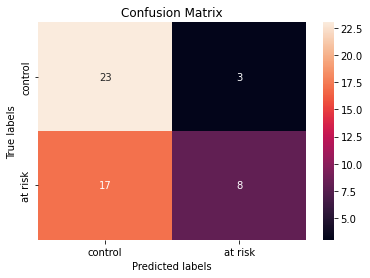

In [62]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [63]:
# with kfold cross validation
k = 6
kf = KFold(n_splits=k, shuffle=True, random_state=None)
model = svm
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.4117647058823529, 0.6470588235294118, 0.47058823529411764, 0.6470588235294118, 0.5882352941176471, 0.6875]
Avg accuracy : 0.5753676470588235


## Logistic Regression model

In [64]:
lr = LogisticRegression(solver='liblinear', random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [65]:
y_pred = lr.predict(X_test)

In [66]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.688


In [67]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

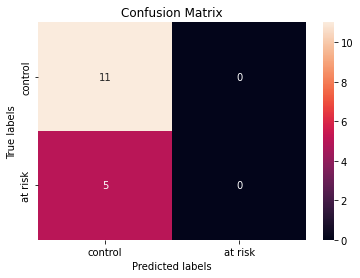

In [68]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [69]:
# with kfold cross validation
k = 6
kf = KFold(n_splits=k, shuffle = True, random_state=None)
model = lr
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.47058823529411764, 0.5294117647058824, 0.5294117647058824, 0.5882352941176471, 0.6470588235294118, 0.6875]
Avg accuracy : 0.5753676470588235


## Decision Tree model

In [70]:
dt = tree.DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [71]:
y_pred = dt.predict(X_test)

In [72]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.438


In [73]:
y_pred

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0])

[Text(0.4583333333333333, 0.9166666666666666, 'X[5] <= 0.003\ngini = 0.494\nsamples = 85\nvalue = [47, 38]'),
 Text(0.375, 0.75, 'X[10] <= -0.0\ngini = 0.476\nsamples = 77\nvalue = [47, 30]'),
 Text(0.16666666666666666, 0.5833333333333334, 'X[9] <= -0.006\ngini = 0.142\nsamples = 13\nvalue = [12, 1]'),
 Text(0.08333333333333333, 0.4166666666666667, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.25, 0.4166666666666667, 'gini = 0.0\nsamples = 12\nvalue = [12, 0]'),
 Text(0.5833333333333334, 0.5833333333333334, 'X[12] <= -0.0\ngini = 0.496\nsamples = 64\nvalue = [35, 29]'),
 Text(0.4166666666666667, 0.4166666666666667, 'X[10] <= -0.0\ngini = 0.245\nsamples = 7\nvalue = [1, 6]'),
 Text(0.3333333333333333, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.5, 0.25, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]'),
 Text(0.75, 0.4166666666666667, 'X[13] <= -0.0\ngini = 0.481\nsamples = 57\nvalue = [34, 23]'),
 Text(0.6666666666666666, 0.25, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 

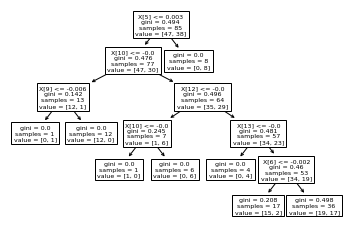

In [74]:
tree.plot_tree(dt)

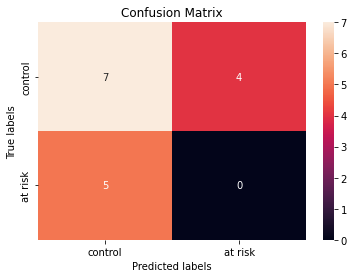

In [75]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [76]:
# with kfold cross validation
k = 6
kf = KFold(n_splits=k, shuffle=True, random_state=None)
model = tree.DecisionTreeClassifier(max_depth=5)
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.6470588235294118, 0.5294117647058824, 0.5294117647058824, 0.5882352941176471, 0.5882352941176471, 0.4375]
Avg accuracy : 0.5533088235294118


## CNN

In [77]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [78]:
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(20,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model.fit(X_train, y_train,epochs=50, batch_size=1, verbose=1,validation_data=(X_test, y_test))

Epoch 1/50
85/85 [==============================] - 0s 2ms/step - loss: 0.7054 - accuracy: 0.5412 - val_loss: 0.6787 - val_accuracy: 0.6250
Epoch 2/50
85/85 [==============================] - 0s 1ms/step - loss: 0.6909 - accuracy: 0.6000 - val_loss: 0.7639 - val_accuracy: 0.3750
Epoch 3/50
85/85 [==============================] - 0s 1ms/step - loss: 0.7118 - accuracy: 0.5176 - val_loss: 0.6675 - val_accuracy: 0.6250
Epoch 4/50
85/85 [==============================] - 0s 1ms/step - loss: 0.7129 - accuracy: 0.4706 - val_loss: 0.6696 - val_accuracy: 0.6250
Epoch 5/50
85/85 [==============================] - 0s 1ms/step - loss: 0.6976 - accuracy: 0.5647 - val_loss: 0.6825 - val_accuracy: 0.6250
Epoch 6/50
85/85 [==============================] - 0s 1ms/step - loss: 0.6922 - accuracy: 0.5647 - val_loss: 0.6663 - val_accuracy: 0.6250
Epoch 7/50
85/85 [==============================] - 0s 1ms/step - loss: 0.7021 - accuracy: 0.4824 - val_loss: 0.6881 - val_accuracy: 0.6250
Epoch 8/50
85/85 [==

# MLP

In [79]:
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier(solver='lbfgs', alpha=0.001, hidden_layer_sizes=(5, 3), random_state=1)
NN.fit(X_train, y_train)
y_pred = NN.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.625


/home/nprins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
